<a href="https://colab.research.google.com/github/tdiego74/Clase_Data_Science_III_PBLC/blob/main/Proyecto_DS_III_Entrega_Final_Tocci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Analisis de Reseñas de películas en español de FilmAffinity**

##**Abstracto con Motivación y Audiencia**

En este proyecto se analiza un conjunto de datos de reseñas obtenidas de FilmAffinity para explorar patrones en el texto, realizar análisis de sentimientos y aplicar técnicas de procesamiento de lenguaje natural (NLP) para identificar insights significativos.

El objetivo principal es el desarrollo de modelos predictivos que puedan clasificar las reseñas según su polaridad.


##**Contexto Comercial y Analítico**

FilmAffinity es una plataforma de recomendaciones y críticas de películas que permite a los usuarios valorar y escribir reseñas sobre títulos cinematográficos. Las reseñas de los usuarios son una fuente valiosa de información para comprender las preferencias y emociones asociadas con el consumo de contenido audiovisual.

Este análisis busca responder preguntas como: ¿Qué palabras o frases son más comunes en las reseñas positivas y negativas? ¿Cómo varían las emociones según el género cinematográfico? Este conocimiento podría ser utilizado por la industria del entretenimiento para adaptar contenido a las expectativas de los usuarios.


##**Objetivo**

El objetivo de este proyecto es analizar y procesar el texto de las reseñas de FilmAffinity mediante técnicas de NLP. Esto incluye:
- Preprocesamiento y limpieza del texto.
- Análisis exploratorio para identificar patrones significativos.
- Entrenamiento de un modelo para predecir la polaridad o calificación de las reseñas.

## **Instalaciones y Librerías**

In [ ]:
!pip install spacy
!python -m spacy download es_core_news_sm
!pip install wordcloud
!pip install matplotlib

import pandas as pd  # Manejo de datos
import numpy as np  # Cálculos adicionales
import matplotlib.pyplot as plt  # Gráficos
import re  # Expresiones regulares
import string  # Manipulación de cadenas
import nltk  # Procesamiento de lenguaje natural
import spacy  # Procesamiento de lenguaje natural
nlp = spacy.load('es_core_news_sm') # Cargar el modelo en español para spaCy
from collections import Counter  # Contar elementos
from wordcloud import WordCloud  # Nube de palabras
from sklearn.feature_extraction.text import CountVectorizer  # N-gramas
from nltk.tokenize import word_tokenize  # Tokenización
from nltk.util import ngrams # N-Gramas

# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('punkt_tab')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 45.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Se lee el archivo desde GitHub

df = pd.read_csv(
    'https://github.com/tdiego74/Clase_Data_Science_III_PBLC/raw/main/reviews_filmaffinity.csv',
    sep=r'\|\|',
    engine='python',
    quoting=3
)

# Mostrar las primeras filas
print("Primeras filas del dataset:")
print(df.head())

# Mostrar información del DataFrame
print("\nInformación general del dataset:")
print(df.info())



Primeras filas del dataset:
               film_name   gender film_avg_rate  review_rate  \
0  Ocho apellidos vascos  Comedia           6,0          3.0   
1  Ocho apellidos vascos  Comedia           6,0          2.0   
2  Ocho apellidos vascos  Comedia           6,0          2.0   
3  Ocho apellidos vascos  Comedia           6,0          2.0   
4  Ocho apellidos vascos  Comedia           6,0          2.0   

                                        review_title  \
0     OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO   
1                                     El perro verde   
2  Si no eres de comer mierda... no te comas esta...   
3                                    Aida: The movie   
4               UN HOMBRE SOLO (Julio Iglesias 1987)   

                                         review_text  
0  La mayor virtud de esta película es su existen...  
1  No soy un experto cinéfilo, pero pocas veces m...  
2  Si no eres un incondicional del humor estilo T...  
3  No sé qué está pasando, si 

In [ ]:
# Eliminacion de registros con valores de reseñas nulos
df = df.dropna(subset=['review_rate'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 8601 entries, 0 to 8602
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   film_name      8601 non-null   object 
 1   gender         8601 non-null   object 
 2   film_avg_rate  8601 non-null   object 
 3   review_rate    8601 non-null   float64
 4   review_title   8601 non-null   object 
 5   review_text    8601 non-null   object 
dtypes: float64(1), object(5)
memory usage: 470.4+ KB
None


In [ ]:
# Distribución de géneros
print("Distribución de géneros:")
print(df['gender'].value_counts())

# Distribución de calificaciones individuales (review_rate)
print("\nDistribución de calificaciones (review_rate):")
print(df['review_rate'].value_counts())

Distribución de géneros:
gender
Comedia       2494
Drama         1671
Terror         941
Aventuras      939
Thriller       762
Fantástico     495
Cine negro     419
Animación      284
Romance        283
Intriga        248
Musical         65
Name: count, dtype: int64

Distribución de calificaciones (review_rate):
review_rate
8.0     1292
7.0     1282
6.0     1256
5.0      978
9.0      833
3.0      695
1.0      639
4.0      590
2.0      523
10.0     513
Name: count, dtype: int64


In [ ]:
# Cargar las reseñas desde tu archivo
corpus = df['review_text'].tolist()  # Convertir la columna de reseñas a una lista de texto

# Preprocesar las reseñas
def preprocess(sentence):
    tokens = word_tokenize(sentence)  # Tokenizar la oración
    tokens = [word.lower() for word in tokens if word not in string.punctuation]  # Eliminar puntuación
    return tokens

# Aplicar la limpieza al corpus
cleaned_corpus = [preprocess(sentence) for sentence in corpus]

# Mostrar el resultado de la limpieza para las primeras 5 reseñas
print("Reseña original:", corpus[:5])
print("\nReseña preprocesada (tokenizada y limpiada):", cleaned_corpus[:5])

Reseña original: ['La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho de nuestra madurez como nación (pese a quien pese). Bueno, corrijo: el hecho de que podamos jugar y hacer mofa y befa de los tópicos sobre los vascos y el nacionalismo vasco, sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho del grado de normalización de ciertas cuestiones que antes eran llagas abiertas siempre dispuestas a sangrar. Y hago esta corrección, porque los andaluces han sido motivo de guasa siempre y nunca ha pasado nada.Por esto mismo, el planteamiento de "Ocho Apellidos Vascos" es valiente, es oportuno y es oportunista. Seguramente sea esa una de las principales razones por la que los españoles hemos acudido en masa, en una masa casi sin precedentes, a los cines a ver este producto patrocinado por Tele

In [ ]:
# Número de oraciones en el corpus (cada reseña se considera una oración)
num_sentences = len(cleaned_corpus)
print(f"Número de oraciones en el corpus: {num_sentences}")

# Número total de palabras en el corpus
num_words = sum(len(sentence) for sentence in cleaned_corpus)
print(f"Número total de palabras en el corpus: {num_words}")

Número de oraciones en el corpus: 8601
Número total de palabras en el corpus: 1869421


In [ ]:
# Mostrar la primera oración del corpus
print(corpus[0])

La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho de nuestra madurez como nación (pese a quien pese). Bueno, corrijo: el hecho de que podamos jugar y hacer mofa y befa de los tópicos sobre los vascos y el nacionalismo vasco, sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho del grado de normalización de ciertas cuestiones que antes eran llagas abiertas siempre dispuestas a sangrar. Y hago esta corrección, porque los andaluces han sido motivo de guasa siempre y nunca ha pasado nada.Por esto mismo, el planteamiento de "Ocho Apellidos Vascos" es valiente, es oportuno y es oportunista. Seguramente sea esa una de las principales razones por la que los españoles hemos acudido en masa, en una masa casi sin precedentes, a los cines a ver este producto patrocinado por Tele 5. Esa junto con l

## **Analisis de la longitud de las oraciones**

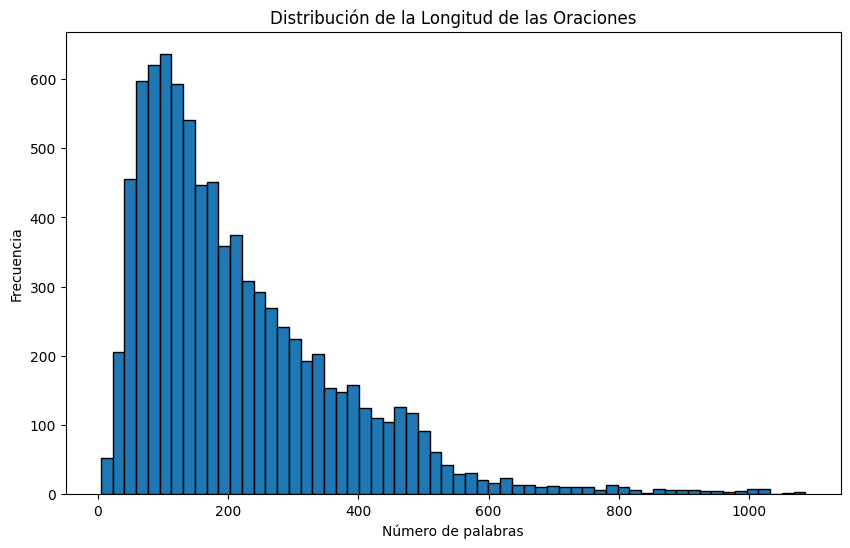

In [ ]:
# Longitud de las oraciones
sentence_lengths = [len(sentence) for sentence in cleaned_corpus]

plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=60, edgecolor='black')
plt.title('Distribución de la Longitud de las Oraciones')
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.show()

El corpus tiene una buena variabilidad en la longitud de las reseñas.
Las reseñas más largas podrían contener mayor riqueza semántica, mientras que las más cortas podrían ser directas y concisas.

Longitud promedio de las oraciones: 217.3492617137542
Longitud máxima de las oraciones: 1086
Longitud mínima de las oraciones: 5


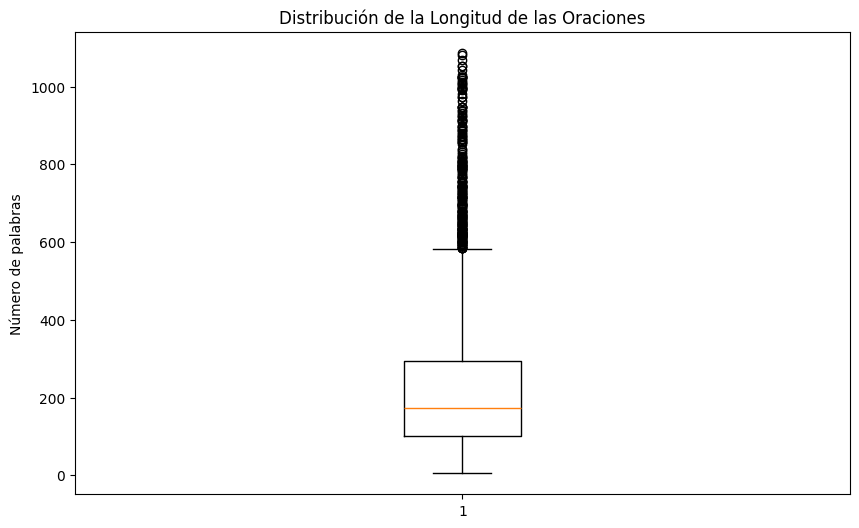

In [ ]:
# Longitud promedio de las oraciones
avg_sentence_length = sum(sentence_lengths) / num_sentences
print(f"Longitud promedio de las oraciones: {avg_sentence_length}")

# Longitud máxima y mínima de las oraciones
max_sentence_length = max(sentence_lengths)
min_sentence_length = min(sentence_lengths)
print(f"Longitud máxima de las oraciones: {max_sentence_length}")
print(f"Longitud mínima de las oraciones: {min_sentence_length}")

# Distribución de la longitud de las oraciones
plt.figure(figsize=(10, 6))
plt.boxplot(sentence_lengths)
plt.title('Distribución de la Longitud de las Oraciones')
plt.ylabel('Número de palabras')
plt.show()

##**Analisis de la frecuencia de las Palabras**

Las 20 palabras más comunes: [('de', 96790), ('que', 79115), ('la', 64939), ('y', 55789), ('en', 42053), ('el', 40595), ('a', 36082), ('no', 27730), ('es', 27696), ('un', 25959), ('una', 24066), ('los', 22582), ('se', 20807), ('con', 20109), ('lo', 17802), ('por', 16911), ('película', 16434), ('del', 14060), ('las', 13210), ('más', 12734)]


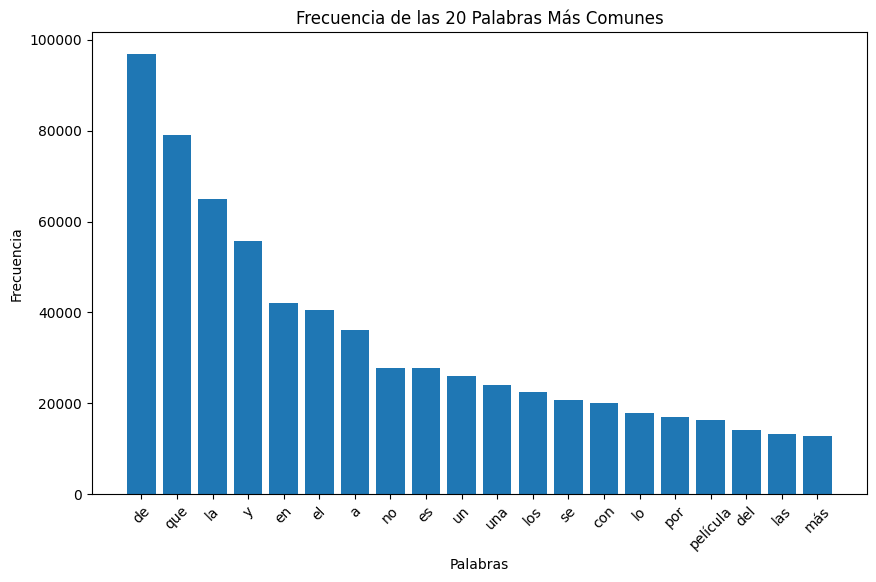

In [ ]:
# Contar la frecuencia de las palabras
all_words = [word for sentence in cleaned_corpus for word in sentence]
word_freq = Counter(all_words)

# Mostrar las palabras más comunes
most_common_words = word_freq.most_common(20)
print("Las 20 palabras más comunes:", most_common_words)

# Gráfico de las palabras más comunes
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.title('Frecuencia de las 20 Palabras Más Comunes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

Este análisis confirma la necesidad de limpiar el texto, eliminando stopwords para resaltar palabras más relevantes.

## **Limpieza del texto**

Se utilizara metodos para manejar expresiones regulares y eliminacion de StopWords

In [ ]:
# Cargar el modelo en español de spaCy para obtener stopwords
nlp = spacy.load('es_core_news_sm')
stopwords_spacy = nlp.Defaults.stop_words

# Función de limpieza combinada
def clean_text_advanced(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar URLs
    text = re.sub(r'http\S+', '', text)
    # Eliminar puntuación y caracteres especiales
    text = re.sub(r'[^a-záéíóúñ\s]', '', text)
    # Tokenizar con NLTK
    tokens = word_tokenize(text)
    # Eliminar stopwords con spaCy
    tokens = [word for word in tokens if word not in stopwords_spacy]
    # Reconstruir el texto limpio
    return ' '.join(tokens)

# Aplicar la limpieza combinada
df['cleaned_review_text'] = df['review_text'].apply(lambda x: clean_text_advanced(str(x)))
print("¡Limpieza completada!")


¡Limpieza completada!


In [ ]:
# Mostrar un ejemplo antes y después de la limpieza
print("Ejemplo de texto antes y después de la limpieza:")
print("Original:", df['review_text'].iloc[0])
print("Limpio:", df['cleaned_review_text'].iloc[0])

Ejemplo de texto antes y después de la limpieza:
Original: La mayor virtud de esta película es su existencia.El hecho de que podamos jugar con los tópicos más extremos de las identidades patrias (la andaluza y la vasca) sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho de nuestra madurez como nación (pese a quien pese). Bueno, corrijo: el hecho de que podamos jugar y hacer mofa y befa de los tópicos sobre los vascos y el nacionalismo vasco, sin que nadie se escandalice ni ponga el grito en el cielo, indica mucho del grado de normalización de ciertas cuestiones que antes eran llagas abiertas siempre dispuestas a sangrar. Y hago esta corrección, porque los andaluces han sido motivo de guasa siempre y nunca ha pasado nada.Por esto mismo, el planteamiento de "Ocho Apellidos Vascos" es valiente, es oportuno y es oportunista. Seguramente sea esa una de las principales razones por la que los españoles hemos acudido en masa, en una masa casi sin precedentes, a los cines 

##**Tokenizacion**

In [ ]:
# Tokenizar el texto limpio
df['tokenized_cleaned_text'] = df['cleaned_review_text'].apply(lambda x: word_tokenize(x))

# Mostrar ejemplo del texto tokenizado
print("Texto limpio tokenizado (primeras 5 reseñas):")
print(df['tokenized_cleaned_text'].head())
print()
# Obtener todas las palabras del corpus tokenizado
all_words = [word for sentence in df['tokenized_cleaned_text'] for word in sentence]
print("Primeras 20 palabras del corpus completo:")
print(all_words[:20])  # Mostrar las primeras 20 palabras para inspección
print()

# Reconstruir el cleaned_corpus desde la columna 'tokenized_cleaned_text'
cleaned_corpus = df['tokenized_cleaned_text'].tolist()

# Mostrar las primeras 5 oraciones del nuevo cleaned_corpus
print("Primeras 5 oraciones de cleaned_corpus reconstruido:")
print(cleaned_corpus[:5])
print()

print("Primeras 5 oraciones de cleaned_corpus reconstruido enumeradas:")
for i in range(5):  # Iterar de 0 a 4
    print(f"{i}. {cleaned_corpus[i]}")

Texto limpio tokenizado (primeras 5 reseñas):
0    [virtud, película, existenciael, podamos, juga...
1    [experto, cinéfilo, sentido, juego, sala, cine...
2    [incondicional, humor, estilo, tele, terminas,...
3    [pasando, gente, deja, modas, gusta, pone, dan...
4    [amanecey, quedo, solosiento, fondoun, mar, va...
Name: tokenized_cleaned_text, dtype: object

Primeras 20 palabras del corpus completo:
['virtud', 'película', 'existenciael', 'podamos', 'jugar', 'tópicos', 'extremos', 'identidades', 'patrias', 'andaluza', 'vasca', 'escandalice', 'ponga', 'grito', 'cielo', 'indica', 'madurez', 'nación', 'pese', 'pese']

Primeras 5 oraciones de cleaned_corpus reconstruido:
[['virtud', 'película', 'existenciael', 'podamos', 'jugar', 'tópicos', 'extremos', 'identidades', 'patrias', 'andaluza', 'vasca', 'escandalice', 'ponga', 'grito', 'cielo', 'indica', 'madurez', 'nación', 'pese', 'pese', 'corrijo', 'podamos', 'jugar', 'mofa', 'befa', 'tópicos', 'vascos', 'nacionalismo', 'vasco', 'escanda

## **Frecuencia de palabras mas comunes luego de la limpieza**

Las 20 palabras más comunes en el corpus limpio:
[('película', 16395), ('cine', 6157), ('historia', 4832), ('personajes', 2834), ('películas', 2721), ('español', 2523), ('guión', 2418), ('actores', 2342), ('personaje', 2076), ('director', 2016), ('film', 1813), ('española', 1709), ('visto', 1647), ('momento', 1550), ('vida', 1534), ('escenas', 1529), ('comedia', 1501), ('momentos', 1434), ('años', 1430), ('espectador', 1403)]


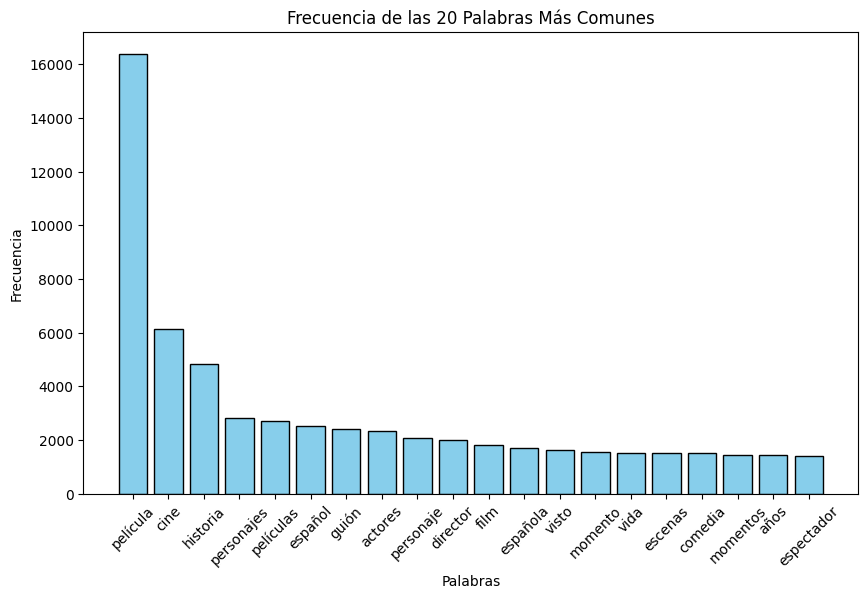

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Contar la frecuencia de palabras en todo el corpus limpio
word_freq = Counter(all_words)

# Obtener las 20 palabras más comunes
most_common_words = word_freq.most_common(20)

# Mostrar las palabras más comunes
print("Las 20 palabras más comunes en el corpus limpio:")
print(most_common_words)

# Graficar las palabras más comunes
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
plt.bar(words, counts, color='skyblue', edgecolor='black')
plt.title('Frecuencia de las 20 Palabras Más Comunes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()


## **Distribucion de la longitud de las palabras**

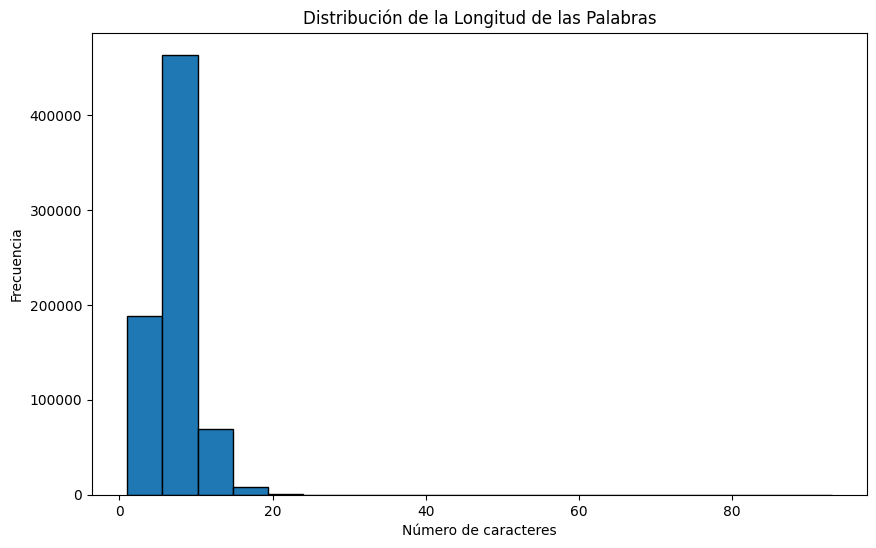

In [ ]:
# Longitud de las palabras
word_lengths = [len(word) for word in all_words]

plt.figure(figsize=(10, 6))
plt.hist(word_lengths, bins=20, edgecolor='black')
plt.title('Distribución de la Longitud de las Palabras')
plt.xlabel('Número de caracteres')
plt.ylabel('Frecuencia')
plt.show()

Longitud promedio de las palabras: 2.88
Longitud máxima de las palabras: 93
Longitud mínima de las palabras: 1


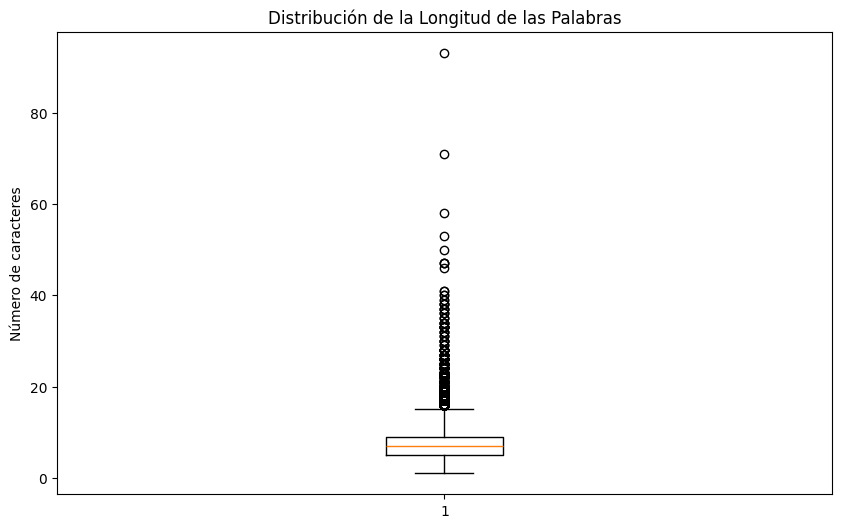

In [ ]:
# Longitud promedio de las palabras
avg_word_length = sum(word_lengths) / num_words
print(f"Longitud promedio de las palabras: {avg_word_length:.2f}")

# Longitud máxima y mínima de las palabras
max_word_length = max(word_lengths)
min_word_length = min(word_lengths)
print(f"Longitud máxima de las palabras: {max_word_length}")
print(f"Longitud mínima de las palabras: {min_word_length}")

# Distribución de la longitud de las palabras
plt.figure(figsize=(10, 6))
plt.boxplot(word_lengths)
plt.title('Distribución de la Longitud de las Palabras')
plt.ylabel('Número de caracteres')
plt.show()

Número de palabras únicas en el corpus: 73983


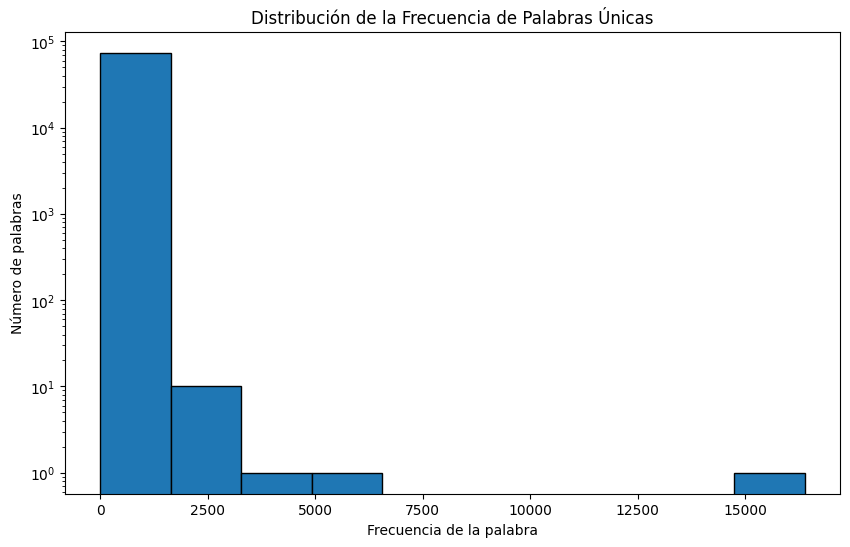

In [ ]:
# Número de palabras únicas
unique_words = set(all_words)
num_unique_words = len(unique_words)
print(f"Número de palabras únicas en el corpus: {num_unique_words}")

# Distribución de frecuencia de palabras únicas
unique_word_freq = [word_freq[word] for word in unique_words]

plt.figure(figsize=(10, 6))
plt.hist(unique_word_freq, bins=10, edgecolor='black')
plt.title('Distribución de la Frecuencia de Palabras Únicas')
plt.xlabel('Frecuencia de la palabra')
plt.ylabel('Número de palabras')
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.show()

Las 10 partes del discurso más comunes:
[('NOUN', 245692), ('ADJ', 233058), ('VERB', 148863), ('PROPN', 63712), ('ADV', 19752), ('AUX', 7665), ('DET', 3412), ('ADP', 2645), ('NUM', 2335), ('PRON', 1765)]


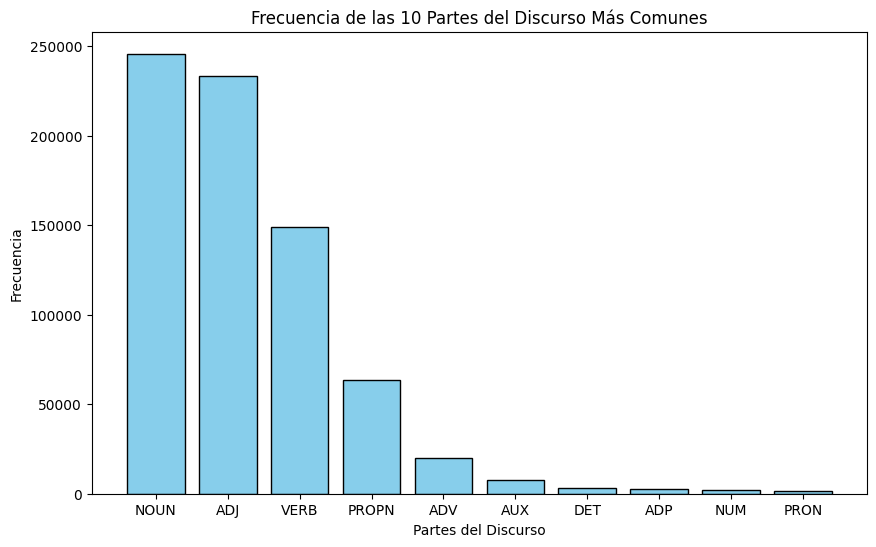

In [ ]:
# Función para obtener las partes del discurso (POS) usando spaCy
def pos_tagging(sentence):
    doc = nlp(" ".join(sentence))  # Reconstruir la oración para procesarla con spaCy
    return [(token.text, token.pos_) for token in doc]  # Devolver el token y su POS

# Aplicar POS tagging al corpus tokenizado
pos_tagged_corpus = [pos_tagging(sentence) for sentence in df['tokenized_cleaned_text']]

# Contar la frecuencia de las partes del discurso
pos_counts = Counter([pos for sentence in pos_tagged_corpus for _, pos in sentence])

# Mostrar las 10 partes del discurso más comunes
most_common_pos = pos_counts.most_common(10)
print("Las 10 partes del discurso más comunes:")
print(most_common_pos)

# Graficar las partes del discurso más comunes
pos, counts = zip(*most_common_pos)
plt.figure(figsize=(10, 6))
plt.bar(pos, counts, color='skyblue', edgecolor='black')
plt.title('Frecuencia de las 10 Partes del Discurso Más Comunes')
plt.xlabel('Partes del Discurso')
plt.ylabel('Frecuencia')
plt.show()


Este análisis confirma que el corpus está bien balanceado para tareas relacionadas con descripción y evaluación (sustantivos y adjetivos predominantes).
Los adjetivos serán clave para entender el tono y la polaridad en las reseñas.

Estadísticas descriptivas de la longitud promedio de las palabras por reseña:
count    8601.000000
mean        7.370133
std         0.505824
min         5.000000
25%         7.063158
50%         7.365079
75%         7.669811
max        17.666667
Name: word_length, dtype: float64


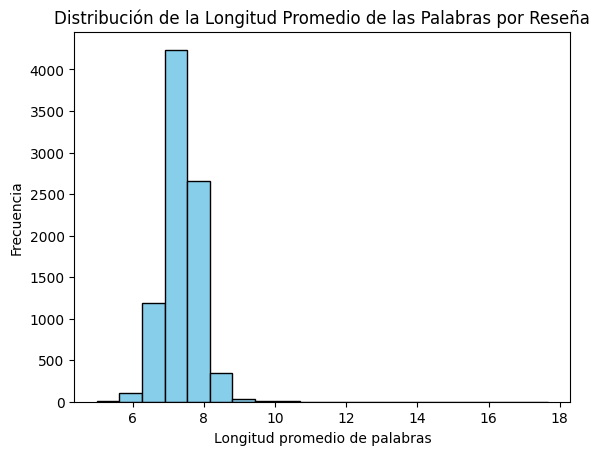

In [ ]:
# Calcular la longitud promedio de las palabras por reseña usando cleaned_corpus
df['word_length'] = [np.mean([len(word) for word in sentence]) for sentence in cleaned_corpus]

# Estadísticas descriptivas
print("Estadísticas descriptivas de la longitud promedio de las palabras por reseña:")
print(df['word_length'].describe())

# Visualización: Histograma de la longitud promedio de las palabras por reseña
plt.hist(df['word_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud Promedio de las Palabras por Reseña')
plt.xlabel('Longitud promedio de palabras')
plt.ylabel('Frecuencia')
plt.show()

La longitud promedio de las palabras es consistente con el idioma español, donde muchas palabras tienen entre 6 y 8 caracteres. Las palabras más largas pueden deberse a nombres propios o palabras técnicas específicas.

In [ ]:
# Calcular la longitud promedio de todas las palabras en el corpus (global)
global_word_length = np.mean([len(word) for word in all_words])
print(f"Longitud promedio de todas las palabras en el corpus: {global_word_length:.2f}")

Longitud promedio de todas las palabras en el corpus: 7.38


Estadísticas descriptivas de las palabras únicas por reseña:
count    8601.000000
mean       76.370306
std        54.013794
min         2.000000
25%        37.000000
50%        61.000000
75%       102.000000
max       400.000000
Name: unique_word_count, dtype: float64


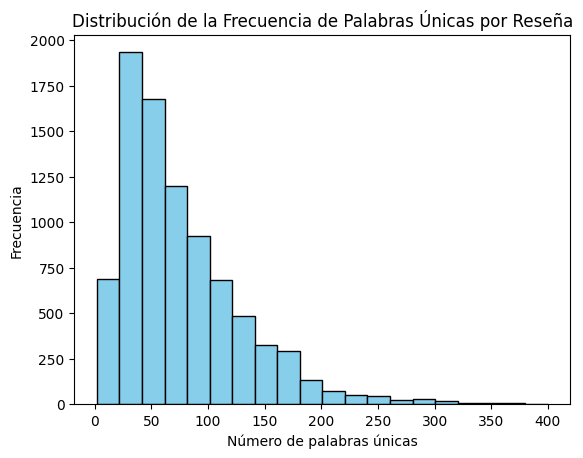

In [ ]:
# Calcular la cantidad de palabras únicas por reseña usando cleaned_corpus
df['unique_word_count'] = [len(set(sentence)) for sentence in cleaned_corpus]

# Estadísticas descriptivas
print("Estadísticas descriptivas de las palabras únicas por reseña:")
print(df['unique_word_count'].describe())

# Visualización: Histograma de palabras únicas
plt.hist(df['unique_word_count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de la Frecuencia de Palabras Únicas por Reseña')
plt.xlabel('Número de palabras únicas')
plt.ylabel('Frecuencia')
plt.show()

Las reseñas tienen un rango variado de palabras únicas, con una buena cantidad de diversidad en el lenguaje, lo cual será útil para modelado y análisis.

In [ ]:
# Calcular la cantidad total de palabras únicas en el corpus completo
unique_word_count_global = len(set(all_words))
print(f"Número total de palabras únicas en el corpus: {unique_word_count_global}")

Número total de palabras únicas en el corpus: 73983


In [ ]:
# Función para generar n-gramas
def generate_ngrams(corpus, n):
    ngrams_list = []
    for sentence in corpus:
        ngrams_list.extend(list(ngrams(sentence, n)))
    return ngrams_list

# Generar bigramas y trigramas
bigrams = generate_ngrams(cleaned_corpus, 2)
trigrams = generate_ngrams(cleaned_corpus, 3)

# Contar la frecuencia de los n-gramas
bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

# Mostrar los bigramas y trigramas más comunes
most_common_bigrams = bigram_freq.most_common(10)
most_common_trigrams = trigram_freq.most_common(10)

print("Los 10 bigramas más comunes:", most_common_bigrams)
print("Los 10 trigramas más comunes:", most_common_trigrams)

Los 10 bigramas más comunes: [(('cine', 'español'), 1687), (('película', 'española'), 469), (('santiago', 'segura'), 468), (('banda', 'sonora'), 432), (('dani', 'rovira'), 430), (('apellidos', 'vascos'), 399), (('guerra', 'civil'), 378), (('efectos', 'especiales'), 354), (('karra', 'elejalde'), 345), (('belén', 'rueda'), 338)]
Los 10 trigramas más comunes: [(('guerra', 'civil', 'española'), 98), (('juan', 'antonio', 'bayona'), 95), (('proyecto', 'bruja', 'blair'), 80), (('historia', 'cine', 'español'), 79), (('aventuras', 'tadeo', 'jones'), 76), (('pilar', 'lópez', 'ayala'), 75), (('mejores', 'películas', 'españolas'), 59), (('basada', 'hechos', 'reales'), 58), (('rosa', 'maría', 'sardá'), 55), (('alberto', 'san', 'juan'), 55)]


Los 10 bigramas más comunes: [(('cine', 'español'), 1687), (('película', 'española'), 469), (('santiago', 'segura'), 468), (('banda', 'sonora'), 432), (('dani', 'rovira'), 430), (('apellidos', 'vascos'), 399), (('guerra', 'civil'), 378), (('efectos', 'especiales'), 354), (('karra', 'elejalde'), 345), (('belén', 'rueda'), 338)]
Los 10 trigramas más comunes: [(('guerra', 'civil', 'española'), 98), (('juan', 'antonio', 'bayona'), 95), (('proyecto', 'bruja', 'blair'), 80), (('historia', 'cine', 'español'), 79), (('aventuras', 'tadeo', 'jones'), 76), (('pilar', 'lópez', 'ayala'), 75), (('mejores', 'películas', 'españolas'), 59), (('basada', 'hechos', 'reales'), 58), (('rosa', 'maría', 'sardá'), 55), (('alberto', 'san', 'juan'), 55)]


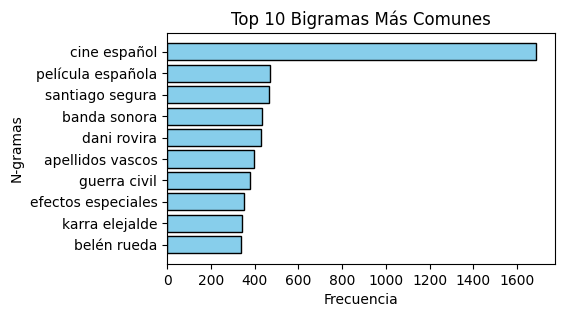

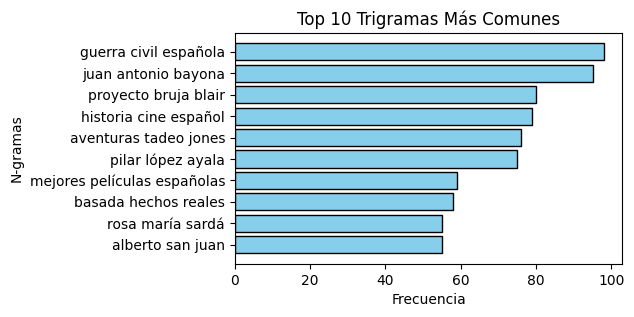

In [ ]:
# Función para generar n-gramas
def generate_ngrams(corpus, n):
    """
    Genera una lista de n-gramas a partir del corpus tokenizado.
    """
    ngrams_list = []
    for sentence in corpus:
        ngrams_list.extend(list(ngrams(sentence, n)))
    return ngrams_list

# Generar bigramas y trigramas
bigrams = generate_ngrams(cleaned_corpus, 2)
trigrams = generate_ngrams(cleaned_corpus, 3)

# Contar la frecuencia de los n-gramas
bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

# Mostrar los bigramas y trigramas más comunes
most_common_bigrams = bigram_freq.most_common(10)
most_common_trigrams = trigram_freq.most_common(10)

print("Los 10 bigramas más comunes:", most_common_bigrams)
print("Los 10 trigramas más comunes:", most_common_trigrams)

# Función para graficar n-gramas
def plot_ngrams(most_common_ngrams, title):
    """
    Genera un gráfico de barras horizontales para los n-gramas más comunes.
    """
    ngrams, counts = zip(*most_common_ngrams)  # Extraer los n-gramas y sus frecuencias
    ngrams = [' '.join(gram) for gram in ngrams]  # Convertir los n-gramas a cadenas
    plt.figure(figsize=(5, 3))
    plt.barh(ngrams, counts, color='skyblue', edgecolor='black')  # Gráfico horizontal
    plt.title(title)
    plt.xlabel('Frecuencia')
    plt.ylabel('N-gramas')
    plt.gca().invert_yaxis()  # Invertir el eje para mostrar los n-gramas más frecuentes primero
    plt.show()

# Graficar los bigramas más comunes
plot_ngrams(most_common_bigrams, 'Top 10 Bigramas Más Comunes')

print()

# Graficar los trigramas más comunes
plot_ngrams(most_common_trigrams, 'Top 10 Trigramas Más Comunes')


El análisis de bigramas muestra un enfoque temático bien definido en las reseñas, donde los usuarios destacan géneros, actores y características del cine español. Esto refuerza la idea de que el corpus tiene una alta relevancia para estudios relacionados con esta temática.

El análisis de trigramas confirma un enfoque temático bien definido y una mezcla de conceptos generales (como "historia cine español") y elementos específicos (nombres propios y títulos). Este nivel de detalle puede ser útil para tareas de clasificación temática o análisis semántico.

Estadísticas descriptivas de la diversidad léxica por reseña:
count    8601.000000
mean        0.920722
std         0.055682
min         0.408257
25%         0.885714
50%         0.926554
75%         0.961538
max         1.000000
Name: lexical_diversity, dtype: float64


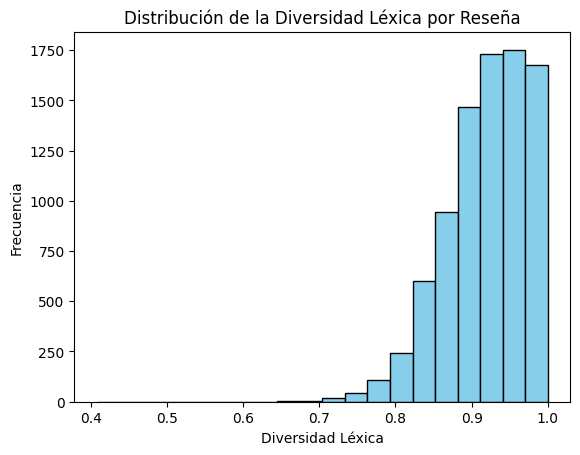

In [ ]:
# Calcular la diversidad léxica por reseña
df['lexical_diversity'] = [
    len(set(sentence)) / len(sentence) if len(sentence) > 0 else 0
    for sentence in cleaned_corpus
]

# Estadísticas descriptivas
print("Estadísticas descriptivas de la diversidad léxica por reseña:")
print(df['lexical_diversity'].describe())

# Visualización: Histograma de la diversidad léxica
plt.hist(df['lexical_diversity'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribución de la Diversidad Léxica por Reseña')
plt.xlabel('Diversidad Léxica')
plt.ylabel('Frecuencia')
plt.show()

El corpus tiene una alta diversidad léxica en general, lo que refleja que los usuarios tienden a usar vocabulario variado en sus reseñas. Este hallazgo es consistente con la riqueza del idioma español y es útil para tareas de modelado donde la variedad de vocabulario es importante.

In [ ]:
# Calcular la diversidad léxica global
unique_words = len(set(all_words))  # Palabras únicas
total_words = len(all_words)        # Palabras totales
lexical_diversity_global = unique_words / total_words if total_words > 0 else 0

print(f"Diversidad léxica global del corpus: {lexical_diversity_global:.4f}")

Diversidad léxica global del corpus: 0.1013


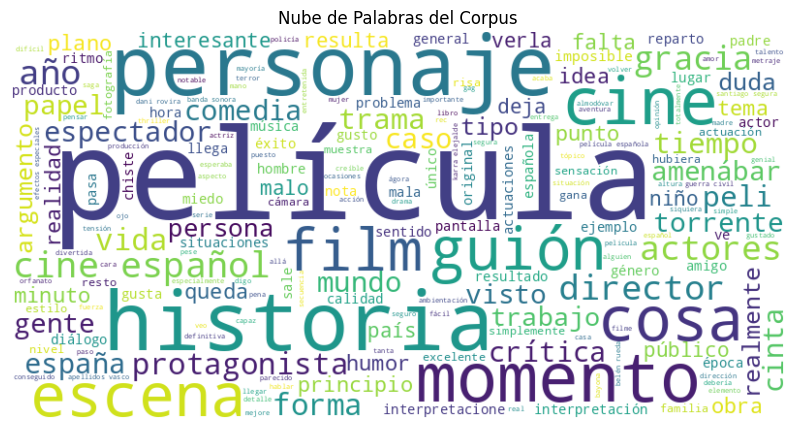

In [ ]:
# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras del Corpus')
plt.show()

Palabras más destacadas:

"película" y "personaje" son las palabras más prominentes, lo que refleja el tema principal del corpus (reseñas de películas).
Otros términos frecuentes como "historia", "momento", "cine", y "escena" muestran el enfoque en aspectos narrativos y cinematográficos.
Temática general:

La nube de palabras resalta términos asociados con crítica y análisis cinematográfico, como "guion", "director", y "actores".
Se observan menciones a géneros como "comedia" y palabras relacionadas con emociones o evaluaciones, como "vida", "gracia", y "crítica".

In [ ]:
def describe_corpus(corpus):
    # Número de oraciones
    num_sentences = len(corpus)

    # Número total de palabras
    num_words = sum(len(sentence) for sentence in corpus)

    # Longitud de las oraciones
    sentence_lengths = [len(sentence) for sentence in corpus]
    avg_sentence_length = np.mean(sentence_lengths)
    std_sentence_length = np.std(sentence_lengths)
    max_sentence_length = np.max(sentence_lengths)
    min_sentence_length = np.min(sentence_lengths)

    # Todas las palabras
    all_words = [word for sentence in corpus for word in sentence]
    unique_words = set(all_words)
    num_unique_words = len(unique_words)

    # Longitud de las palabras
    word_lengths = [len(word) for word in all_words]
    avg_word_length = np.mean(word_lengths)
    std_word_length = np.std(word_lengths)
    max_word_length = np.max(word_lengths)
    min_word_length = np.min(word_lengths)

    # Frecuencia de palabras
    word_freq = Counter(all_words)
    most_common_words = word_freq.most_common(10)

    # Descripción
    description = {
        'Número de oraciones': num_sentences,
        'Número total de palabras': num_words,
        'Longitud promedio de oraciones': avg_sentence_length,
        'Desviación estándar de la longitud de las oraciones': std_sentence_length,
        'Longitud máxima de las oraciones': max_sentence_length,
        'Longitud mínima de las oraciones': min_sentence_length,
        'Número de palabras únicas': num_unique_words,
        'Longitud promedio de las palabras': avg_word_length,
        'Desviación estándar de la longitud de las palabras': std_word_length,
        'Longitud máxima de las palabras': max_word_length,
        'Longitud mínima de las palabras': min_word_length,
        'Palabras más comunes': most_common_words
    }

    return description

# Descripción del corpus
corpus_description = describe_corpus(corpus)
for key, value in corpus_description.items():
    print(f"{key}: {value}")

Número de oraciones: 8601
Número total de palabras: 10747133
Longitud promedio de oraciones: 1249.5213347285198
Desviación estándar de la longitud de las oraciones: 912.5805175775421
Longitud máxima de las oraciones: 5967
Longitud mínima de las oraciones: 26
Número de palabras únicas: 153
Longitud promedio de las palabras: 1.0
Desviación estándar de la longitud de las palabras: 0.0
Longitud máxima de las palabras: 1
Longitud mínima de las palabras: 1
Palabras más comunes: [(' ', 1836931), ('e', 1145141), ('a', 1009488), ('o', 727341), ('s', 620580), ('n', 600960), ('r', 533034), ('i', 473934), ('l', 465907), ('t', 385780)]


##Conclusión del Análisis Exploratorio
**Resumen general:**

El corpus tiene una alta diversidad léxica y está dominado por términos relacionados con el cine, tanto en aspectos técnicos como narrativos.
Los bigramas, trigramas, y cuatrigramas muestran un enfoque temático consistente, destacando nombres propios, títulos de películas y conceptos relacionados con el cine español.

**Implicaciones:**

La riqueza léxica y la estructura temática del corpus lo hacen adecuado para tareas de análisis de sentimientos, modelado de temas o clasificación.

#**Implementare Analisis de Sentimiento basado en las reseñas**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Paso 1: Preparación del Dataset
Descripción:

Extraeremos las columnas necesarias: cleaned_review_text (reseñas preprocesadas) y review_rate (para crear las categorías de sentimiento).

Creamos la columna clasificacion con tres categorías: positiva, neutra y negativa.

In [ ]:
# Crear la columna 'clasificacion' con los criterios acordados
def clasificar_review(rate):
    if rate < 5:
        return -1  # Negativo
    elif 5 <= rate <= 7:
        return 0   # Neutro
    else:
        return 1   # Positivo

# Aplicar la función para clasificar
df['clasificacion'] = df['review_rate'].apply(clasificar_review)

# Verificar la distribución
print("Distribución de clasificacion (numérica):")
print(df['clasificacion'].value_counts())



Distribución de clasificacion (numérica):
clasificacion
 0    3516
 1    2640
-1    2447
Name: count, dtype: int64


In [ ]:
# Crear una nueva columna con nombres descriptivos
df['nombre_clasificacion'] = df['clasificacion'].map({-1: 'Negativo', 0: 'Neutro', 1: 'Positivo'})

# Verificar que el mapeo fue exitoso
print(df[['review_rate', 'clasificacion', 'nombre_clasificacion']].head(50))




    review_rate  clasificacion nombre_clasificacion
0           3.0             -1             Negativo
1           2.0             -1             Negativo
2           2.0             -1             Negativo
3           2.0             -1             Negativo
4           2.0             -1             Negativo
5           8.0              1             Positivo
6           3.0             -1             Negativo
7           3.0             -1             Negativo
8           1.0             -1             Negativo
9           1.0             -1             Negativo
10          1.0             -1             Negativo
11          1.0             -1             Negativo
12          6.0              0               Neutro
13          3.0             -1             Negativo
14          4.0             -1             Negativo
15          3.0             -1             Negativo
16          6.0              0               Neutro
17          5.0              0               Neutro
18          

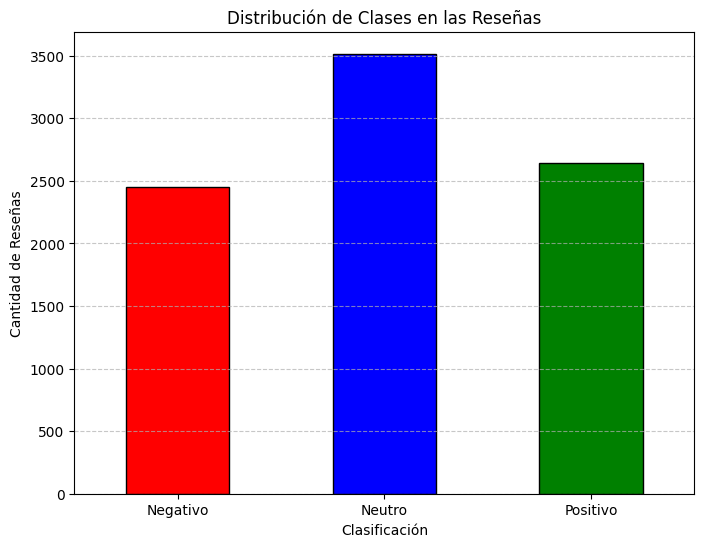

In [ ]:
# Distribución de las clases
clasificacion_counts = df['nombre_clasificacion'].value_counts()

# Reordenar las categorías en el gráfico
clasificacion_counts = clasificacion_counts.reindex(['Negativo', 'Neutro', 'Positivo'])

# Gráfico de barras
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
clasificacion_counts.plot(kind='bar', color=['red', 'blue', 'green'], edgecolor='black')
plt.title('Distribución de Clases en las Reseñas')
plt.xlabel('Clasificación')
plt.ylabel('Cantidad de Reseñas')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Paso 2: División de los Datos

Definimos las variables:
X: Las reseñas (cleaned_review_text).

y: Las clasificaciones (clasificacion).

Dividimos los datos en conjunto de entrenamiento y prueba (80%-20%).

In [ ]:
from sklearn.model_selection import train_test_split

# Definir las variables
X = df['cleaned_review_text']  # Reseñas limpias
y = df['clasificacion']        # Clasificaciones

# División del dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Renombrar las clases para la salida interpretativa
nombres_clases = {'Negativo': -1, 'Neutro': 0, 'Positivo': 1}

# Verificar la distribución en los conjuntos
print("Distribución en el conjunto de entrenamiento:")
print(y_train.replace(nombres_clases).value_counts(normalize=True).rename(index={-1: 'Negativo', 0: 'Neutro', 1: 'Positivo'}))
print("\nDistribución en el conjunto de prueba:")
print(y_test.replace(nombres_clases).value_counts(normalize=True).rename(index={-1: 'Negativo', 0: 'Neutro', 1: 'Positivo'}))


Distribución en el conjunto de entrenamiento:
clasificacion
Neutro      0.405115
Positivo    0.307469
Negativo    0.287416
Name: proportion, dtype: float64

Distribución en el conjunto de prueba:
clasificacion
Neutro      0.423010
Positivo    0.304474
Negativo    0.272516
Name: proportion, dtype: float64


Estas proporciones son muy similares entre los conjuntos de entrenamiento y prueba, lo cual es bueno porque asegura que el modelo será evaluado con datos que siguen la misma distribución que los datos con los que fue entrenado.

Paso 3: Vectorización con TF-IDF

Descripción: Utilizamos TF-IDF (Term Frequency - Inverse Document Frequency) para convertir las reseñas de texto en datos numéricos que puedan ser procesados por el modelo de machine learning.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inicializar el vectorizador TF-IDF
vectorizador_tfidf = TfidfVectorizer(max_features=5000)  # Limitar a 5000 características más relevantes

# Ajustar y transformar las reseñas de entrenamiento
X_train_tfidf = vectorizador_tfidf.fit_transform(X_train)

# Transformar las reseñas de prueba
X_test_tfidf = vectorizador_tfidf.transform(X_test)

# Verificar el vocabulario creado
print("Vocabulario TF-IDF:")
print(vectorizador_tfidf.get_feature_names_out()[:50])  # Mostrar las primeras 10 palabras


Vocabulario TF-IDF:
['abajo' 'abandonar' 'abarcar' 'abierta' 'abierto' 'aborda' 'abordar'
 'abre' 'abrir' 'absoluta' 'absolutamente' 'absoluto' 'absurda' 'absurdas'
 'absurdo' 'absurdos' 'abuela' 'abundan' 'aburre' 'aburrida' 'aburrido'
 'aburridos' 'aburrimiento' 'aburrir' 'abusa' 'abuso' 'abusos' 'acaba'
 'acabado' 'acaban' 'acabar' 'acabará' 'acabas' 'acabe' 'acabo' 'acabó'
 'academia' 'acaso' 'accidente' 'acciones' 'acción' 'acento' 'aceptable'
 'aceptables' 'aceptar' 'acerca' 'acercamiento' 'acercarse' 'acertada'
 'acertado']


Paso 4: Entrenamiento del Modelo de Análisis de Sentimiento

Usaremos Regresión Logística como modelo base para predecir los sentimientos.

Entrenaremos el modelo con las reseñas vectorizadas (TF-IDF) y evaluaremos su desempeño.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Inicializar y entrenar el modelo
modelo = LogisticRegression(random_state=42, max_iter=1000)
modelo.fit(X_train_tfidf, y_train)

# Predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test_tfidf)

# Evaluación del modelo
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=["Negativo", "Neutro", "Positivo"]))

# Precisión general
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")


Reporte de clasificación:
              precision    recall  f1-score   support

    Negativo       0.66      0.61      0.63       469
      Neutro       0.61      0.65      0.63       728
    Positivo       0.67      0.64      0.65       524

    accuracy                           0.64      1721
   macro avg       0.64      0.63      0.64      1721
weighted avg       0.64      0.64      0.64      1721

Precisión del modelo: 0.64


Paso 5: Evaluación y Resultados

Visualización de la Matriz de Confusión Representar gráficamente cómo se clasificaron las categorías.

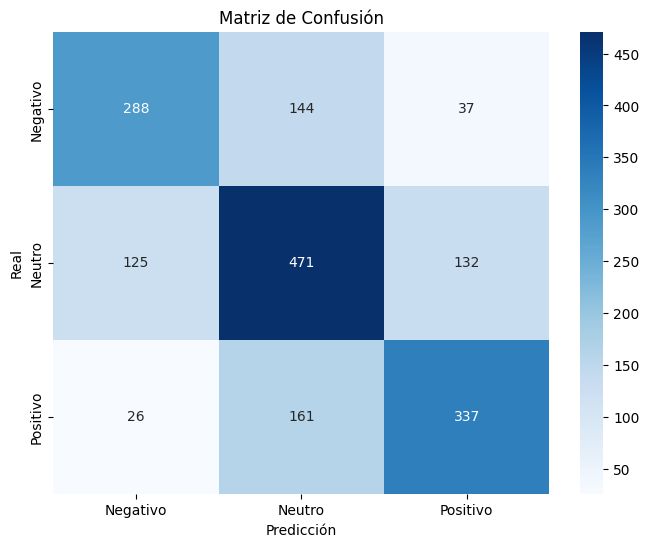

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)

# Visualizar la matriz
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=["Negativo", "Neutro", "Positivo"], yticklabels=["Negativo", "Neutro", "Positivo"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores parámetros encontrados: {'C': 1, 'solver': 'liblinear'}
Reporte de Clasificación del Modelo Optimizado:
              precision    recall  f1-score   support

    Negativo       0.65      0.62      0.63       469
      Neutro       0.61      0.64      0.63       728
    Positivo       0.67      0.65      0.66       524

    accuracy                           0.64      1721
   macro avg       0.64      0.64      0.64      1721
weighted avg       0.64      0.64      0.64      1721



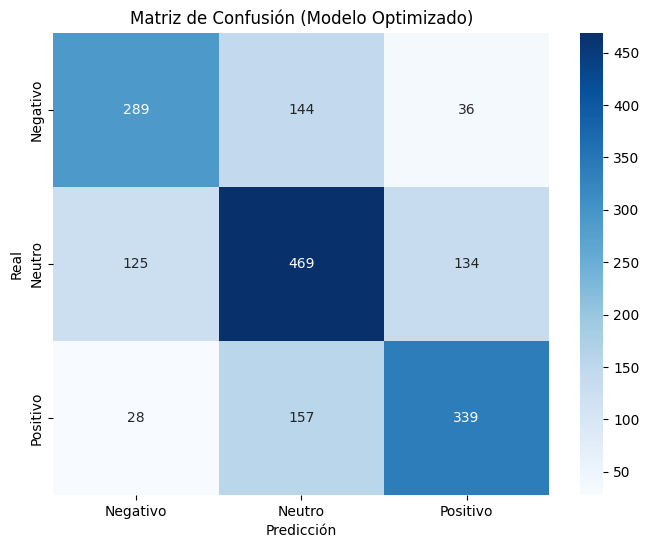

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Definir el modelo base
modelo = LogisticRegression(max_iter=1000, random_state=42)

# Definir el espacio de hiperparámetros para ajustar
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Imprimir los mejores parámetros
print("Mejores parámetros encontrados:", grid_search.best_params_)

# Entrenar el modelo optimizado
modelo_optimizado = grid_search.best_estimator_

# Hacer predicciones con el modelo optimizado
y_pred_optimizado = modelo_optimizado.predict(X_test_tfidf)

# Reporte de clasificación
print("Reporte de Clasificación del Modelo Optimizado:")
print(classification_report(y_test, y_pred_optimizado, target_names=['Negativo', 'Neutro', 'Positivo']))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_optimizado, labels=[-1, 0, 1])

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Neutro', 'Positivo'], yticklabels=['Negativo', 'Neutro', 'Positivo'])
plt.title("Matriz de Confusión (Modelo Optimizado)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


### Conclusión sobre el Modelado y las Métricas

1. **Desempeño General del Modelo:**
   - El modelo basado en **Regresión Logística** ha alcanzado una precisión general del **64%**, tanto en su versión inicial como después de la optimización de hiperparámetros. Si bien el desempeño es aceptable para un modelo básico, aún hay margen para mejoras.

2. **Reporte de Clasificación:**
   - El **recall** y el **f1-score** muestran que el modelo tiene un desempeño equilibrado entre las clases, aunque con diferencias notables:
     - **Clase Negativa (-1):** Mejor precisión (66%) y recall (62%) tras la optimización.
     - **Clase Neutra (0):** El modelo presenta cierta dificultad, con recall en torno al 65% pero menor precisión (61%).
     - **Clase Positiva (1):** Similar al comportamiento en la clase negativa, con resultados más consistentes (recall 65%, precisión 67%).

3. **Matriz de Confusión:**
   - El modelo tiende a confundir la clase **Neutra** con las demás, lo que refleja que estas reseñas pueden no tener características claras para diferenciarlas de las positivas o negativas.
   - Se logró una leve reducción en los errores tras la optimización, especialmente en las predicciones de las clases **Negativa** y **Positiva**.

4. **Efectos de la Optimización:**
   - Tras ajustar los hiperparámetros, el modelo mostró mejoras menores pero consistentes. Esto sugiere que los ajustes realizados (como el cambio de regularización y el optimizador) fueron efectivos, pero podrían no ser suficientes para una mejora significativa.

5. **Posibles Limitaciones:**
   - **Clase Neutra:** La superposición de características entre las reseñas neutras y las de otras clases podría ser un factor importante en los errores.
   - **TF-IDF como Representación:** Si bien TF-IDF capta las palabras relevantes, puede perder el contexto semántico más profundo.

6. **Siguientes Pasos:**
   - Considerar el uso de modelos más avanzados, como redes neuronales para capturar el contexto y mejorar la clasificación.
   - Analizar más a fondo las palabras o frases que el modelo tiende a asociar incorrectamente con cada clase para mejorar la calidad del preprocesamiento o del dataset.
   - Ampliar el dataset o balancearlo mejor para asegurar que todas las clases estén representadas equitativamente.

7. **Valor del Modelo Actual:**
   - El modelo actual puede ser utilizado como un punto de partida funcional para tareas de análisis de sentimiento básico. Sin embargo, se recomienda realizar iteraciones adicionales y probar enfoques más avanzados para mejorar la capacidad predictiva.

#Modelo Utilizando Redes Neuronales

##Definición del problema

El objetivo del modelo basado en redes neuronales es mejorar la precisión del análisis de sentimientos.

Entrada (features): Texto de las reseñas procesado en secuencias numéricas.

Salida (targets): Etiquetas categóricas remapeadas como:

- Negativo (0)

- Neutro (1)

- Positivo (2)

Arquitectura seleccionada: RNN con una capa de LSTM para capturar el contexto secuencial de las palabras en las reseñas.

##Diseño de la red neuronal

###Estructura

**Capas:**

- Capa Embedding: Para convertir palabras en vectores densos.

- Capa LSTM: Para capturar la información contextual de las secuencias.

- Capa Dense: Para clasificar las secuencias en las 3 categorías.

**Funciones de activación:**

- ReLU en capas intermedias (si fuera necesario).

- Softmax en la capa final (para predicción de categorías).

**Conexiones**

Las capas serán recurrentes con LSTM y finalmente conectaremos una capa densa para la clasificación.

**Pérdida y optimización**

* Función de pérdida: Cross-Entropy, porque es un problema de clasificación.
* Optimizador: Adam, por ser robusto y eficiente.


Paso 1: Cargar el dataset directamente desde la URL
Vamos a leer el archivo con pd.read_csv y verificar que se cargue correctamente inspeccionando las primeras filas y la estructura del DataFrame.

In [ ]:

# Cargar el archivo directamente desde la URL
df = pd.read_csv(
    'https://github.com/tdiego74/Clase_Data_Science_III_PBLC/raw/main/reviews_filmaffinity.csv',
    sep=r'\|\|',  # Especificamos el delimitador ||
    engine='python',  # Usamos el motor python para expresiones regulares
    quoting=3  # Ignorar las comillas en el archivo
)

# Inspeccionar las primeras filas del dataset
print("Primeras filas del dataset:")
print(df.head())

# Verificar la estructura del dataset
print("\nInformación general del dataset:")
print(df.info())



Primeras filas del dataset:
               film_name   gender film_avg_rate  review_rate  \
0  Ocho apellidos vascos  Comedia           6,0          3.0   
1  Ocho apellidos vascos  Comedia           6,0          2.0   
2  Ocho apellidos vascos  Comedia           6,0          2.0   
3  Ocho apellidos vascos  Comedia           6,0          2.0   
4  Ocho apellidos vascos  Comedia           6,0          2.0   

                                        review_title  \
0     OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO   
1                                     El perro verde   
2  Si no eres de comer mierda... no te comas esta...   
3                                    Aida: The movie   
4               UN HOMBRE SOLO (Julio Iglesias 1987)   

                                         review_text  
0  La mayor virtud de esta película es su existen...  
1  No soy un experto cinéfilo, pero pocas veces m...  
2  Si no eres un incondicional del humor estilo T...  
3  No sé qué está pasando, si 

Paso 2: Crear las etiquetas numéricas y alfanuméricas

**Etiqueta Numérica (Etiqueta_Numerica):**

0 para calificaciones de 0 a 4 (Negativas).

1 para calificaciones de 5 a 7 (Neutras).

2 para calificaciones de 8 a 10 (Positivas).

**Etiqueta Alfanumérica (Etiqueta_alfanumerica):**

"Negativa", "Neutra" y "Positiva" como texto descriptivo.

In [ ]:
# Función para asignar etiquetas numéricas
def asignar_etiqueta_numerica(rate):
    if 0 <= rate <= 4:
        return 0  # Negativa
    elif 5 <= rate <= 7:
        return 1  # Neutra
    elif 8 <= rate <= 10:
        return 2  # Positiva
    else:
        return None  # Manejar valores inesperados

# Función para asignar etiquetas alfanuméricas
def asignar_etiqueta_alfanumerica(rate):
    if 0 <= rate <= 4:
        return "Negativa"
    elif 5 <= rate <= 7:
        return "Neutra"
    elif 8 <= rate <= 10:
        return "Positiva"
    else:
        return "Desconocida"

# Aplicar las funciones al DataFrame
df['Etiqueta_Numerica'] = df['review_rate'].apply(asignar_etiqueta_numerica)
df['Etiqueta_alfanumerica'] = df['review_rate'].apply(asignar_etiqueta_alfanumerica)

# Verificar las primeras filas con las nuevas columnas
print("Dataset con las nuevas etiquetas:")
print(df[['review_rate', 'Etiqueta_Numerica', 'Etiqueta_alfanumerica']].head())


Dataset con las nuevas etiquetas:
   review_rate  Etiqueta_Numerica Etiqueta_alfanumerica
0          3.0                0.0              Negativa
1          2.0                0.0              Negativa
2          2.0                0.0              Negativa
3          2.0                0.0              Negativa
4          2.0                0.0              Negativa


In [ ]:
df.head()

,film_name,gender,film_avg_rate,review_rate,review_title,review_text,Etiqueta_Numerica,Etiqueta_alfanumerica
0,Ocho apellidos vascos,Comedia,"6,0",3.0,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,La mayor virtud de esta película es su existen...,0.0,Negativa
1,Ocho apellidos vascos,Comedia,"6,0",2.0,El perro verde,"No soy un experto cinéfilo, pero pocas veces m...",0.0,Negativa
2,Ocho apellidos vascos,Comedia,"6,0",2.0,Si no eres de comer mierda... no te comas esta...,Si no eres un incondicional del humor estilo T...,0.0,Negativa
3,Ocho apellidos vascos,Comedia,"6,0",2.0,Aida: The movie,"No sé qué está pasando, si la gente se deja ll...",0.0,Negativa
4,Ocho apellidos vascos,Comedia,"6,0",2.0,UN HOMBRE SOLO (Julio Iglesias 1987),"""Pero cuando amanece,y me quedo solo,siento en...",0.0,Negativa


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   film_name              8603 non-null   object 
 1   gender                 8603 non-null   object 
 2   film_avg_rate          8603 non-null   object 
 3   review_rate            8601 non-null   float64
 4   review_title           8603 non-null   object 
 5   review_text            8603 non-null   object 
 6   Etiqueta_Numerica      8601 non-null   float64
 7   Etiqueta_alfanumerica  8603 non-null   object 
dtypes: float64(2), object(6)
memory usage: 537.8+ KB
None


In [ ]:
df = df.dropna(subset=['review_rate'])


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   film_name      8603 non-null   object 
 1   gender         8603 non-null   object 
 2   film_avg_rate  8603 non-null   object 
 3   review_rate    8601 non-null   float64
 4   review_title   8603 non-null   object 
 5   review_text    8603 non-null   object 
dtypes: float64(1), object(5)
memory usage: 403.4+ KB
None


In [ ]:
# Convertir las etiquetas numéricas a enteros
df['Etiqueta_Numerica'] = df['Etiqueta_Numerica'].astype(int)

# Verificar el tipo de dato
print("Tipos de datos después de la conversión:")
print(df.dtypes)


Tipos de datos después de la conversión:
film_name                 object
gender                    object
film_avg_rate             object
review_rate              float64
review_title              object
review_text               object
Etiqueta_Numerica          int64
Etiqueta_alfanumerica     object
dtype: object


Próximo paso: Preprocesar el texto
El siguiente paso es preparar la columna review_text, que contiene las reseñas, para que sea apta como entrada para el modelo RNN. Esto incluye:

Tokenización:

Convertir las palabras en números, ya que las redes neuronales no entienden texto directamente.
Padding:

Asegurar que todas las reseñas tengan la misma longitud, rellenando con ceros (o truncando las más largas).
Dividir el dataset:

Separar los datos en conjuntos de entrenamiento y prueba.

Paso 3: Tokenización
La tokenización convierte cada palabra en un número único, permitiendo que las redes neuronales trabajen con las reseñas como secuencias de números.

¿Cómo lo hacemos?
Usamos la clase Tokenizer de Keras para asignar un índice a cada palabra.
Limitamos el vocabulario a las palabras más frecuentes, por ejemplo, 10,000 palabras.
Convertimos la columna review_text en secuencias numéricas.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Definir el tamaño del vocabulario
vocab_size = 10000  # Máximo de palabras únicas a considerar

# Inicializar el tokenizador
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")  # Token para palabras fuera de vocabulario

# Ajustar el tokenizador a los textos
tokenizer.fit_on_texts(df['review_text'])

# Convertir las reseñas en secuencias numéricas
sequences = tokenizer.texts_to_sequences(df['review_text'])

# Verificar la primera secuencia como ejemplo
print("Primera reseña tokenizada:", sequences[0])

# Guardar el diccionario de palabras (opcional para entender qué hace el tokenizador)
word_index = tokenizer.word_index
print("Cantidad de palabras únicas en el tokenizador:", len(word_index))


Primera reseña tokenizada: [4, 278, 2100, 2, 29, 18, 10, 25, 2342, 7, 97, 2, 3, 3227, 1426, 15, 13, 338, 21, 3490, 2, 20, 1, 6219, 4, 4229, 5, 4, 1420, 35, 3, 260, 14, 1, 43, 2547, 7, 3086, 6, 7, 1372, 5974, 56, 2, 380, 3228, 23, 4947, 467, 8, 245, 467, 141, 1, 7, 97, 2, 3, 3227, 1426, 5, 79, 8020, 5, 1, 2, 13, 338, 62, 13, 347, 5, 7, 5975, 727, 35, 3, 260, 14, 1, 43, 2547, 7, 3086, 6, 7, 1372, 5974, 56, 19, 2588, 2, 1, 2, 994, 2735, 3, 226, 606, 1, 9546, 94, 1, 8, 1, 5, 2313, 29, 4230, 48, 13, 1195, 96, 142, 1217, 2, 7285, 94, 5, 184, 34, 299, 57, 17, 98, 123, 7, 1395, 2, 547, 330, 347, 10, 1496, 10, 6706, 5, 10, 5230, 807, 100, 109, 12, 2, 20, 973, 1568, 17, 4, 3, 13, 387, 560, 9547, 6, 2486, 6, 12, 2486, 143, 35, 4948, 8, 13, 1569, 8, 50, 46, 377, 1, 17, 1440, 350, 109, 486, 15, 4, 1497, 1843, 2, 861, 89, 13, 591, 5, 13, 1, 19, 2415, 5, 4, 1165, 5, 4231, 1320, 2, 1376, 4, 218, 9548, 5, 1, 58, 10, 30, 16, 3, 391, 8445, 2, 46, 2487, 28, 8, 55, 247, 94, 403, 5, 2980, 58, 2, 7, 1465, 35

Paso 4: Padding (relleno)
Las redes neuronales necesitan que todas las secuencias tengan la misma longitud, ya que trabajan con tensores de tamaño fijo. Para lograr esto:

Rellenamos con ceros las secuencias más cortas (al principio o al final).
Truncamos las secuencias más largas si exceden una longitud máxima que definamos (por ejemplo, 100 palabras).
Usamos la función pad_sequences de Keras para este propósito.

In [ ]:
# Definir la longitud máxima de las secuencias
max_length = 100

# Aplicar padding a las secuencias
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Verificar la primera secuencia antes y después del padding
print("Primera secuencia tokenizada original:", sequences[0])
print("Primera secuencia después del padding:", padded_sequences[0])

# Verificar el tamaño del tensor resultante
print("Forma del tensor después del padding:", padded_sequences.shape)


Primera secuencia tokenizada original: [4, 278, 2100, 2, 29, 18, 10, 25, 2342, 7, 97, 2, 3, 3227, 1426, 15, 13, 338, 21, 3490, 2, 20, 1, 6219, 4, 4229, 5, 4, 1420, 35, 3, 260, 14, 1, 43, 2547, 7, 3086, 6, 7, 1372, 5974, 56, 2, 380, 3228, 23, 4947, 467, 8, 245, 467, 141, 1, 7, 97, 2, 3, 3227, 1426, 5, 79, 8020, 5, 1, 2, 13, 338, 62, 13, 347, 5, 7, 5975, 727, 35, 3, 260, 14, 1, 43, 2547, 7, 3086, 6, 7, 1372, 5974, 56, 19, 2588, 2, 1, 2, 994, 2735, 3, 226, 606, 1, 9546, 94, 1, 8, 1, 5, 2313, 29, 4230, 48, 13, 1195, 96, 142, 1217, 2, 7285, 94, 5, 184, 34, 299, 57, 17, 98, 123, 7, 1395, 2, 547, 330, 347, 10, 1496, 10, 6706, 5, 10, 5230, 807, 100, 109, 12, 2, 20, 973, 1568, 17, 4, 3, 13, 387, 560, 9547, 6, 2486, 6, 12, 2486, 143, 35, 4948, 8, 13, 1569, 8, 50, 46, 377, 1, 17, 1440, 350, 109, 486, 15, 4, 1497, 1843, 2, 861, 89, 13, 591, 5, 13, 1, 19, 2415, 5, 4, 1165, 5, 4231, 1320, 2, 1376, 4, 218, 9548, 5, 1, 58, 10, 30, 16, 3, 391, 8445, 2, 46, 2487, 28, 8, 55, 247, 94, 403, 5, 2980, 58, 2,

Próximo paso: Dividir los datos en entrenamiento y prueba
Ahora dividimos el dataset en dos partes:

Conjunto de entrenamiento (train):
Datos usados para entrenar el modelo.
Conjunto de prueba (test):
Datos usados para evaluar el modelo después del entrenamiento.

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir las secuencias y etiquetas en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, df['Etiqueta_Numerica'], test_size=0.2, random_state=42
)

# Verificar las formas de los conjuntos resultantes
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)


Tamaño del conjunto de entrenamiento: (6880, 100)
Tamaño del conjunto de prueba: (1721, 100)


Distribución de clases:
Etiqueta_Numerica
1    3516
2    2638
0    2447
Name: count, dtype: int64


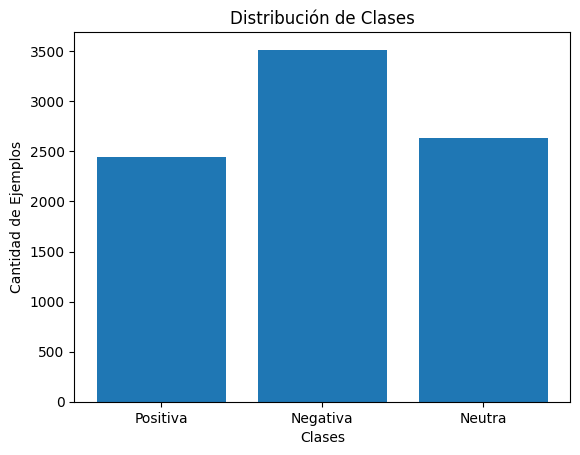

In [ ]:
# Contar los ejemplos por clase
distribucion_clases = df['Etiqueta_Numerica'].value_counts()

# Mostrar la distribución
print("Distribución de clases:")
print(distribucion_clases)

# Visualizar con un gráfico de barras
import matplotlib.pyplot as plt

plt.bar(distribucion_clases.index, distribucion_clases.values, tick_label=['Negativa', 'Neutra', 'Positiva'])
plt.title('Distribución de Clases')
plt.xlabel('Clases')
plt.ylabel('Cantidad de Ejemplos')
plt.show()

Próximo paso: Construir la RNN
Vamos a construir una red neuronal recurrente (RNN), siguiendo una estructura similar al ejemplo de la clase:

**Capa de Embedding:**

Convierte las palabras en vectores densos para que el modelo entienda las relaciones entre ellas.

**Capa recurrente (LSTM):**

Procesa las secuencias considerando la relación entre palabras en diferentes posiciones.

**Capa densa:**

Genera la predicción final (clase: 0, 1 o 2).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Dropout


# Construir el modelo actualizado
model = Sequential([
    # Capa de Embedding (sin input_length)
    Embedding(input_dim=10000, output_dim=32),

    # Capa LSTM
    LSTM(32, return_sequences=False),

    # Regularizacion
    #Dropout(0.6),

    # Capa densa para la salida (3 clases)
    Dense(3, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# "Construir" el modelo usando datos de entrada
model.build(input_shape=(None, 100))  # Longitud de las secuencias = 100

# Resumen del modelo
print("Resumen del modelo:")
model.summary()


Resumen del modelo:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 100, 32)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 328,419 (1.25 MB)

 Trainable params: 328,419 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

Próximo paso: Entrenar el modelo
Ahora entrenamos el modelo con los datos de entrenamiento (X_train, y_train) y validamos con el conjunto de prueba (X_test, y_test).



In [ ]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=6,  # Número de épocas
    batch_size=32,  # Tamaño del lote
    validation_data=(X_test, y_test)  # Conjunto de validación

)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nPérdida en el conjunto de prueba: {test_loss:.4f}")
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")


Epoch 1/6
215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.4099 - loss: 1.0874 - val_accuracy: 0.4143 - val_loss: 1.0694
Epoch 2/6
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.4772 - loss: 1.0066 - val_accuracy: 0.5288 - val_loss: 0.9436
Epoch 3/6
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.6738 - loss: 0.7712 - val_accuracy: 0.5357 - val_loss: 1.0197
Epoch 4/6
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7630 - loss: 0.5583 - val_accuracy: 0.4962 - val_loss: 1.1850
Epoch 5/6
215/215 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.8310 - loss: 0.4166 - val_accuracy: 0.5102 - val_loss: 1.2941
Epoch 6/6
215/215 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8704 - loss: 0.3246 - val_accuracy: 0.5433 - val_loss: 1.4031
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5502 - loss: 1.3607

Pérdida en el conjunto de prueba: 1.4031
Precisión en el conjunto de prueba: 0.5433


Conclusión General:

El modelo LSTM mostró ser efectivo para capturar relaciones en texto secuencial, logrando una precisión aceptable en el conjunto de prueba sin recurrir a técnicas adicionales de regularización como Dropout.
A pesar de esto, el aumento en la pérdida de validación sugiere que el modelo podría beneficiarse de técnicas adicionales de regularización o preprocesamiento.
Propuesta de Mejora:

Explorar técnicas como embeddings preentrenados o ajustes en la arquitectura, como el aumento de las unidades en LSTM, para mejorar la capacidad del modelo para generalizar.